##  訓練データとテストデータを作る際のデータサンプリングついて
[3.1. Cross-validation: evaluating estimator performance — scikit-learn 0.18.1 documentation](http://scikit-learn.org/stable/modules/cross_validation.html#cross-validation)

### ランダムなサンプリング
[sklearn.cross_validation.train_test_split — scikit-learn 0.18.1 documentation](http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.train_test_split.html)

### クラスタを考慮したランダムサンプリング
[sklearn.cross_validation.StratifiedShuffleSplit — scikit-learn 0.17.1 documentation](http://scikit-learn.org/0.17/modules/generated/sklearn.cross_validation.StratifiedShuffleSplit.html#sklearn.cross_validation.StratifiedShuffleSplit)

In [205]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import patsy
import seaborn as sns

from sklearn.cross_validation import train_test_split
import seaborn as sns

exp_values = [
    'Pclass',
#     'PassengerId',
    'C(Sex)',
    'C(Child)',
    'C(Embarked)',
#     'SibSp',
]
predict_value = 'Survived'
child_threthold = 16


def output_result(model, category_data, base_data):
    result = model.predict(category_data)
    with open('data/result.csv', 'w') as f:
        f.write('PassengerId,Survived\n')
        for r, pid in zip(result, base_data['PassengerId']):
            f.write('{},{}\n'.format(pid, str(int(r))))


def category_to_table(titanic, is_training_data=True):
    fomula = '+'.join(exp_values)
    if is_training_data:
        fomula = fomula + '+' + predict_value

    print('fomula:', fomula)

    c_df = patsy.dmatrix(fomula, data=titanic, return_type='dataframe')
    return c_df


def load_titanic_data(is_training_data=True):
    """
    データを読みこみ、
    必要なパラメータに絞る
    """
    def is_child(age):
        if pd.isnull(age):
            return False
        if age < child_threthold:
            return True
        return False
    
    titanic = None
    if is_training_data:
        titanic = pd.read_csv("data/train.csv")
    else:
        titanic = pd.read_csv("data/test.csv")

    if is_training_data:
        subset_ = ['Age', 'Pclass']
        titanic = titanic.dropna(
            subset=subset_
        )
    
    titanic = titanic.assign(
        Child=titanic['Age'].map(is_child),
    )
    return titanic


def hit_rate(predict, test):
    N = len(predict)
    hit = sum([1 if p == t else 0 for p, t in zip(predict, test)])
    return "{0:.3f}%".format(100 * hit/N * 1.0)


def main():
    titanic = load_titanic_data()
    titanic_category = category_to_table(titanic)

    x_columns = list(titanic_category.columns)
    x_columns.remove(predict_value)

    X_train, X_test, Y_train, Y_test = train_test_split(titanic[x_columns],
                                                        titanic[predict_value],
                                                        test_size=0.4,
                                                        random_state=0)


titanic = load_titanic_data()
titanic.head(2)

## カテゴリカルなデータに変換
titanic_category = category_to_table(titanic)
titanic_category.head(2)

fomula: Pclass+C(Sex)+C(Child)+C(Embarked)+Survived


,Intercept,C(Sex)[T.male],C(Child)[T.True],C(Embarked)[T.Q],C(Embarked)[T.S],Pclass,Survived
0,1.0,1.0,0.0,0.0,1.0,3.0,0.0
1,1.0,0.0,0.0,0.0,0.0,1.0,1.0


In [206]:
x_columns = list(titanic_category.columns)
x_columns.remove(predict_value)
x_columns

['Intercept',
 'C(Sex)[T.male]',
 'C(Child)[T.True]',
 'C(Embarked)[T.Q]',
 'C(Embarked)[T.S]',
 'Pclass']

## ランダムサンプリング

In [207]:
from sklearn.cross_validation import train_test_split, StratifiedShuffleSplit


X_train, X_test, Y_train, Y_test = train_test_split(titanic_category[x_columns],
                                                                                        titanic_category[predict_value],
                                                                                        test_size=0.4,
                                                                                        random_state=0)

print(len(X_train), len(X_test))

train_user = set(X_train.index)

training_titanic = titanic.query('PassengerId in @train_user')
test_titanic = titanic.query('PassengerId not in @train_user')

## データに偏りがないかを調べる
pd.concat([X_train.sum(), X_test.sum()], axis=1)

427 285


,0,1
Intercept,427.0,285.0
C(Sex)[T.male],277.0,176.0
C(Child)[T.True],53.0,30.0
C(Embarked)[T.Q],16.0,12.0
C(Embarked)[T.S],328.0,226.0
Pclass,971.0,624.0


## 決定木
### 過学習をさける
```
子ノードの最小数： min_samples_leaf
木の深さ：max_depth
```

hit_rate: 82.105%


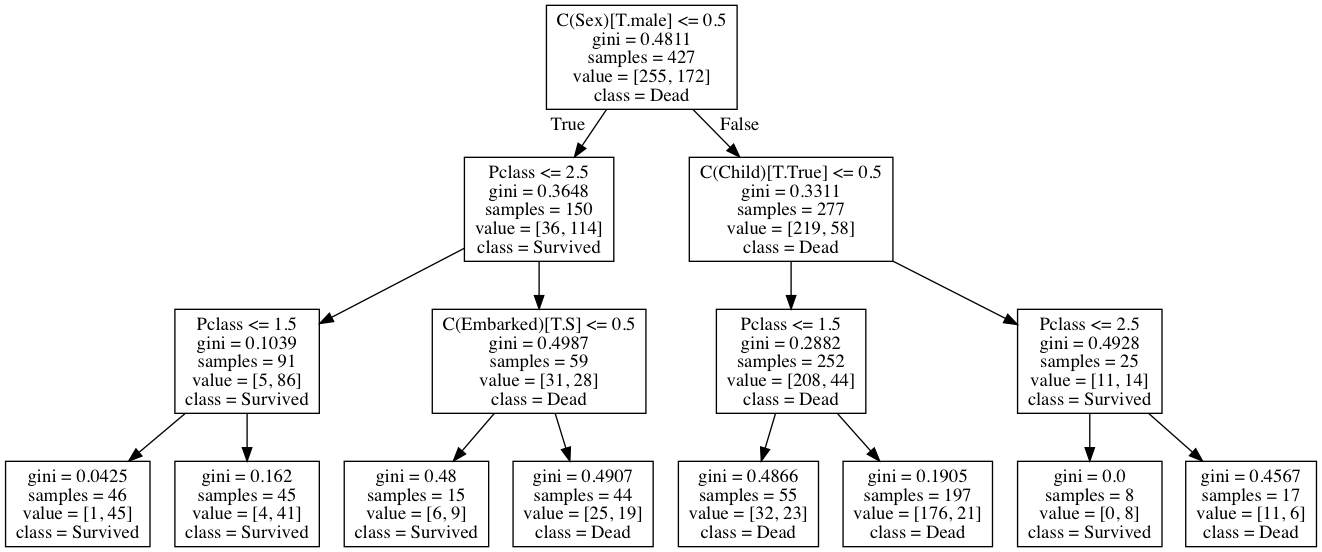

In [208]:
import patsy
from sklearn import tree
from sklearn.feature_extraction import DictVectorizer

decision_tree_model = tree.DecisionTreeClassifier(max_depth=3, min_samples_leaf=8)
decision_tree_model.fit(X_train, Y_train)

predict = decision_tree_model.predict(X_test)
print("hit_rate:", hit_rate(predict, Y_test) )

# 描画
from sklearn.externals.six import StringIO
from IPython.display import Image
import pydotplus

dot_data = StringIO()
tree.export_graphviz(
    decision_tree_model,
    out_file=dot_data,
    feature_names=list(X_train.keys()),
    class_names=['Dead', 'Survived']
)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())

Image(graph.create_png())


In [209]:
parameters = {
    'min_samples_leaf': [2, 5, 7, 10],
    'max_depth': [2,3,4,5]
}
clf = GridSearchCV(tree.DecisionTreeClassifier(), parameters)
clf.fit(X_train, Y_train)

print(clf.best_estimator_)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=2,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')


## ランダムフォレスト

なんだかいい感じにしてくれちゃうランダムフォレスト。
試してみようではないか・・・・。

In [210]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

random_forest_model = RandomForestClassifier(n_estimators=30, random_state=0)
random_forest_model.fit(X_train, Y_train)

parameters = {
    'n_estimators': [5, 10, 20, 30, 50],
#     'max_features': [3, 5, 10, 15, 20],
    'random_state': [0, 10, 50],
    'n_jobs': [1],
    'min_samples_split': [3, 5, 10, 15, 20],
    'max_depth': [3, 5, 10, 15]
}
clf = GridSearchCV(RandomForestClassifier(), parameters)
# clf.fit(X_train, Y_train)

# print(clf.best_estimator_)

In [211]:
clf.best_params_

NotFittedError: This GridSearchCV instance is not fitted yet. Call 'fit' with appropriate arguments before using this method.

In [212]:
random_forest_model = RandomForestClassifier(n_estimators=15, 
                                             min_samples_split=8,
                                             random_state=0,
                                             max_depth=4)
random_forest_model.fit(X_train, Y_train)
predict_random_forest = random_forest_model.predict(X_test)
hit_rate(predict_random_forest, Y_test)

'79.298%'

In [213]:
from sklearn.linear_model import LogisticRegression

lr_model = LogisticRegression()
lr_model.fit(X_train, Y_train)
predict_lr = lr_model.predict(X_test)
hit_rate(predict_random_forest, Y_test)

'79.298%'

In [222]:
# モデルの問題じゃない気がする・・・
#　とりあえず決定木で精度をよくしていこう

decision_tree_model = tree.DecisionTreeClassifier(max_depth=3, min_samples_leaf=8)
decision_tree_model.fit(X_train, Y_train)

predict = decision_tree_model.predict(X_test)
self_predict = decision_tree_model.predict(X_train)

print("hit_rate: {}, (self: {})".format(hit_rate(predict, Y_test), hit_rate(self_predict, Y_train)))

dt_train_result = X_train.assign(
    Result=self_predict
)

dt_test_result = X_test.assign(
    Result=predict_random_forest
)

dt_result_table = pd.concat([dt_train_result, dt_test_result])[['Result']]

result_merged_table = pd.concat([titanic,dt_result_table], axis=1)

result_merged_table.assign(
    Match=result_merged_table['Result']==result_merged_table['Survived']
)


hit_rate: 82.105%, (self: 81.265%)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Child,Result,Match
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,False,0.0,True
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,False,1.0,True
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,False,0.0,False
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,False,1.0,True
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,False,0.0,True
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S,False,0.0,True
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S,True,0.0,True
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S,False,0.0,False
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C,True,1.0,True
10,11,1,3,"Sandstrom, Miss. Marguerite Rut",female,4.0,1,1,PP 9549,16.7000,G6,S,True,0.0,False


In [223]:
result_merged_table

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Child,Result
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,False,0.0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,False,1.0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,False,0.0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,False,1.0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,False,0.0
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S,False,0.0
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S,True,0.0
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S,False,0.0
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C,True,1.0
10,11,1,3,"Sandstrom, Miss. Marguerite Rut",female,4.0,1,1,PP 9549,16.7000,G6,S,True,0.0
